# Введение

В данной работе проводится извлечение и анализ результатов игр по настольному теннису. 

Данные парсятся с сайта https://tt.sport-liga.pro.

Сначала парсим ссылки на турниры (Пример: https://tt.sport-liga.pro/tours/?year=2021&month=06&day=1). Каждый день проводится 10-15 турниров. 

Далее, переходим по каждому ранее полученному турниру (Пример: https://tt.sport-liga.pro/tours/10773) и парсим результаты игр. Нас интересуют очки, кто сколько заработал очков в каждом сете.

# Загрузка и парсинг данных

In [2]:
import requests
from bs4 import BeautifulSoup as BS
import datetime
import pandas as pd 
import re

Парсинг ссылок на турниры.

In [ ]:
BASE_URL = 'https://tt.sport-liga.pro/'

date = datetime.datetime.now() - datetime.timedelta(days=1)
links = []
while date >= datetime.datetime(year=2017, month=7, day=1):
    try:
        html = requests.get(f'https://tt.sport-liga.pro/tours/?year={date.year}&month={date.month}&day={date.day}').text
    except:
        html = requests.get(f'https://tt.sport-liga.pro/tours/?year={date.year}&month={date.month}&day={date.day}').text
    soup = BS(html, 'html.parser')
    links.extend([BASE_URL + list(link.children)[0].get('href') for link in soup.find_all('td', {'class': 'tournament-name'})])
    date = date - datetime.timedelta(days=1)
    print(date)

Сохраним ссылки в .csv файл, чтобы потом не скачивать их заново.

In [42]:
df_links = pd.DataFrame({'link': links})
df_links.to_csv('links.csv')

In [3]:
links = list(pd.read_csv('links.csv')['link'])

Теперь перейдём на страницу каждого турнира и извлечём оттуда результаты игр. Данные так же сохраним в .csv файл.

In [ ]:
games = []
for i, link in enumerate(links):
    html = requests.get(link, headers={'Cache-Control': 'no-cache'}).text
    soup = BS(html, 'html.parser')
    rows = soup.find('table', {'class': 'games_list'}).find_all('tr')[2:]
    for row in rows:
        score = row.find('small', {'class': 'nowrap'})
        if not score:
            continue
        score = re.findall('(\d+)-(\d+)', score.contents[0])
        try:
            games.append({
                'player_1': str(row.find('td', {'class': 'right'}).find('a').contents[0]),
                'player_2': str(row.find_all('td', {'class': 'left'})[1].find('a').contents[0]),
                'player_1_set_1_score': int(score[0][0]) if len(score) >= 1 else None,
                'player_1_set_2_score': int(score[1][0]) if len(score) >= 2 else None,
                'player_1_set_3_score': int(score[2][0]) if len(score) >= 3 else None,
                'player_1_set_4_score': int(score[3][0]) if len(score) >= 4 else None,
                'player_1_set_5_score': int(score[4][0]) if len(score) >= 5 else None,
                'player_2_set_1_score': int(score[0][1]) if len(score) >= 1 else None,
                'player_2_set_2_score': int(score[1][1]) if len(score) >= 2 else None,
                'player_2_set_3_score': int(score[2][1]) if len(score) >= 3 else None,
                'player_2_set_4_score': int(score[3][1]) if len(score) >= 4 else None,
                'player_2_set_5_score': int(score[4][1]) if len(score) >= 5 else None,
            })
        except (AttributeError, IndexError):
            pass
    soup.decompose()
df_games = pd.DataFrame(games)


# Обработка данных

In [2]:
import pandas as pd 

In [3]:
df_games = pd.read_csv('games.csv').drop('Unnamed: 0', axis=1)
df_games

,player_1,player_2,player_1_set_1_score,player_1_set_2_score,player_1_set_3_score,player_1_set_4_score,player_1_set_5_score,player_2_set_1_score,player_2_set_2_score,player_2_set_3_score,player_2_set_4_score,player_2_set_5_score
0,Малахов К,Илюхин Е,7.0,6.0,11.0,11.0,11.0,11.0,11.0,8.0,7.0,9.0
1,Ильин А,Кутузов О,11.0,11.0,11.0,NaN,NaN,7.0,6.0,1.0,NaN,NaN
2,Илюхин Е,Евлахин Д,11.0,10.0,11.0,9.0,11.0,5.0,12.0,4.0,11.0,6.0
3,Малахов К,Ильин А,11.0,2.0,11.0,NaN,NaN,13.0,11.0,13.0,NaN,NaN
4,Евлахин Д,Кутузов О,11.0,11.0,11.0,NaN,NaN,5.0,9.0,4.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
80741,Симонов С,Макаров Д,11.0,9.0,7.0,2.0,NaN,9.0,11.0,11.0,11.0,NaN
80742,Мамазакиров Т,Базилевский В,5.0,11.0,10.0,10.0,NaN,11.0,7.0,12.0,12.0,NaN
80743,Макаров Д,Заргарян М,11.0,9.0,11.0,7.0,11.0,9.0,11.0,4.0,11.0,9.0
80744,Заргарян М,Базилевский В,11.0,11.0,11.0,8.0,11.0,13.0,9.0,2.0,11.0,7.0


In [19]:
df_games.shape

(80746, 12)

Полученный датафрейм имеет размеры 80746 на 12. Таким образом, нам предоставляется возможность проанализировать 80746 игр, по сыгранным сетам и счету в них.

Можно заметить, что колонки с количеством очков партиях или представлено числом типа float, или Nan, если партия не была сыграна. Поскольку количество очков всегда характеризуется целым числом, будет целлесообразно привести колонки с очками игроков к типу Int

In [4]:
df_games[['player_1_set_1_score', 'player_1_set_2_score', 'player_1_set_3_score', 'player_1_set_4_score', 'player_1_set_5_score', 'player_2_set_1_score','player_2_set_2_score','player_2_set_3_score','player_2_set_4_score','player_2_set_5_score']] = df_games[['player_1_set_1_score', 'player_1_set_2_score', 'player_1_set_3_score', 'player_1_set_4_score', 'player_1_set_5_score', 'player_2_set_1_score','player_2_set_2_score','player_2_set_3_score','player_2_set_4_score','player_2_set_5_score']].astype('Int64')
df_games

,player_1,player_2,player_1_set_1_score,player_1_set_2_score,player_1_set_3_score,player_1_set_4_score,player_1_set_5_score,player_2_set_1_score,player_2_set_2_score,player_2_set_3_score,player_2_set_4_score,player_2_set_5_score
0,Малахов К,Илюхин Е,7,6,11,11,11,11,11,8,7,9
1,Ильин А,Кутузов О,11,11,11,<NA>,<NA>,7,6,1,<NA>,<NA>
2,Илюхин Е,Евлахин Д,11,10,11,9,11,5,12,4,11,6
3,Малахов К,Ильин А,11,2,11,<NA>,<NA>,13,11,13,<NA>,<NA>
4,Евлахин Д,Кутузов О,11,11,11,<NA>,<NA>,5,9,4,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...
80741,Симонов С,Макаров Д,11,9,7,2,<NA>,9,11,11,11,<NA>
80742,Мамазакиров Т,Базилевский В,5,11,10,10,<NA>,11,7,12,12,<NA>
80743,Макаров Д,Заргарян М,11,9,11,7,11,9,11,4,11,9
80744,Заргарян М,Базилевский В,11,11,11,8,11,13,9,2,11,7


# Создание новых признаков

На основе имеющихся сведений в датафрейме, можно добавить новые признаки. Например, победителя матча. 

In [5]:
df_games['first_player_won'] = df_games['player_1_set_5_score'] > df_games['player_2_set_5_score']
df_games['first_player_won'] = df_games.loc[(df_games.first_player_won.isnull()), 'first_player_won'] = df_games['player_1_set_4_score'] > df_games['player_2_set_4_score']
df_games['first_player_won'] = df_games.loc[(df_games.first_player_won.isnull()), 'first_player_won'] = df_games['player_1_set_3_score'] > df_games['player_2_set_3_score']
df_games['first_player_won']

0         True
1         True
2         True
3        False
4         True
         ...  
80741    False
80742    False
80743     True
80744     True
80745     True
Name: first_player_won, Length: 80746, dtype: boolean

Была добавлена колонка 'first_player_won'. Значение true соответсвует победе в матче первого игрока, false - второго

Создадим еще одну колонку с количеством сыгранных сетов.

In [6]:
df_games['set_count'] = 5
df_games.loc[(df_games.player_1_set_5_score.isnull()), 'set_count'] = 4
df_games.loc[(df_games.player_1_set_4_score.isnull()), 'set_count'] = 3
df_games['set_count']

0        5
1        3
2        5
3        3
4        3
        ..
80741    4
80742    4
80743    5
80744    5
80745    4
Name: set_count, Length: 80746, dtype: int64

# Визуализация

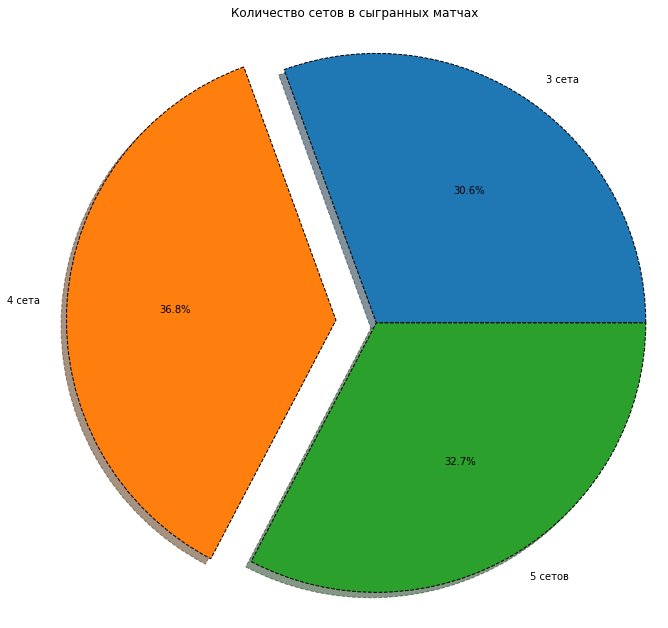

In [7]:
import matplotlib.pyplot as plt
sets = [df_games[df_games["set_count"] == 3].count()['set_count'], 
        df_games[df_games["set_count"] == 4].count()['set_count'],
        df_games[df_games["set_count"] == 5].count()['set_count']]
labels = [  "3 сета",
            "4 сета",
            "5 сетов"]
explode = (0, 0.15, 0)
fig,ax = plt.subplots(figsize=(11, 11))
ax.set_title("Количество сетов в сыгранных матчах", fontsize=12 )
ax.pie(x=sets, labels=labels, autopct='%1.1f%%', shadow=True,
explode=explode, wedgeprops={'lw':1, 'ls':'--','edgecolor':'k'})
ax.axis('equal')
plt.show()

На диаграмме отражены доли матчей, сыгранных до 3-ех побед из 3-ех, 4-ех и 5-ти сетов. Можно заметить, что в целом распределение относительно ровное. Наибольшую долю занимают матчи сыгранные из 4-ех сетов.

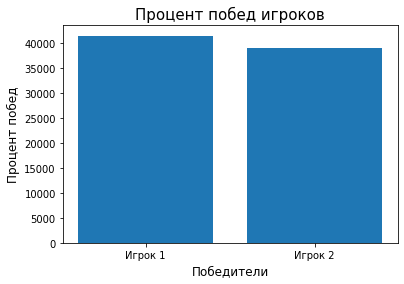

0.5153548836111007 2471


In [8]:
winners = [ df_games[df_games["first_player_won"] == True].count()['first_player_won'], 
            df_games[df_games["first_player_won"] == False].count()['first_player_won']]
labels = ['Игрок 1', 'Игрок 2']
plt.bar(labels,winners)
plt.title("Процент побед игроков", fontsize=15)
plt.xlabel('Победители', fontsize=12)
plt.ylabel("Процент побед", fontsize=12)
plt.show()
print(winners[0]/(winners[0] + winners[1]), winners[0] - winners[1])

На графике отражены доли побед первых и вторых игроков. Можно увидеть, что в целом победы распределяются равномерно. Небольшой перевес побед наблюдается у первых игроков. У них на 2188 побед больше. В процентном соотношении это выглядит как 51% на 49%.

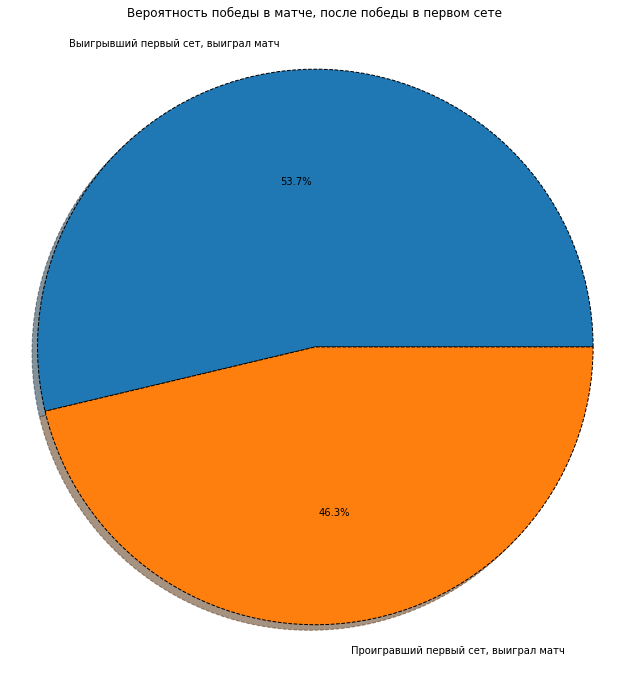

37241 43222


In [9]:
df_games['first_set_first_winner'] = df_games["player_1_set_1_score"] > df_games["player_2_set_1_score"]
df_games['won_first_set_won_match'] = df_games['first_set_first_winner'] == df_games["first_player_won"]
labels = [  "Выигрывший первый сет, выиграл матч",
            "Проигравший первый сет, выиграл матч"]
info = [df_games[df_games["won_first_set_won_match"] == True].count()['won_first_set_won_match'], 
        df_games[df_games["won_first_set_won_match"] == False].count()['won_first_set_won_match']]
explode = (0, 0)
fig,ax = plt.subplots(figsize=(11, 12))
ax.set_title("Вероятность победы в матче, после победы в первом сете", fontsize=12 )
ax.pie(x=info, labels=labels, autopct='%1.1f%%', shadow=True,
explode=explode, wedgeprops={'lw':1, 'ls':'--','edgecolor':'k'})
ax.axis('equal')
plt.show()
print(df_games[df_games["won_first_set_won_match"] == False].count()['won_first_set_won_match'], df_games[df_games["won_first_set_won_match"] == True].count()['won_first_set_won_match'])

На графике показана, вероятность с которой в матче победит победитель первого сета. Можно увидеть, что вероятность такого события 53.7%. И из нашей выборки таких случаев на 5966 больше, чем обратных. 

# Работа с Pandas

In [33]:
if df_games["player_1"].describe().top == df_games["player_2"].describe().top:
    print(df_games["player_1"].describe().top)
    print(df_games["player_1"].describe().freq + df_games["player_2"].describe().freq)

Полетаев И
1388


Игроком с наибольшим количество игр является "Полетаев И". Он провел наибольшее количество матчей и в качестве первого игрока, и в качестве второго. Он провел в общей сложности 1388 игр. 

In [59]:
test_df = df_games.groupby(['player_1']).sum()
test_df

,player_1_set_1_score,player_1_set_2_score,player_1_set_3_score,player_1_set_4_score,player_1_set_5_score,player_2_set_1_score,player_2_set_2_score,player_2_set_3_score,player_2_set_4_score,player_2_set_5_score,first_player_won,set_count,first_set_first_winner,won_first_set_won_match
player_1,,,,,,,,,,,,,,
Абаимова Е,703.0,683.0,746.0,527.0,255.0,695.0,710.0,697.0,515.0,219.0,44,301,35,43
Абаноков З,1379.0,1358.0,1470.0,986.0,495.0,1595.0,1603.0,1556.0,1014.0,499.0,72,640,56,78
Абельмасов И,2440.0,2473.0,2447.0,1954.0,987.0,2444.0,2467.0,2448.0,1937.0,959.0,129,1080,133,128
Абраамян Г,56.0,45.0,48.0,39.0,15.0,40.0,49.0,43.0,38.0,22.0,4,21,5,4
Абраамян Э,243.0,283.0,307.0,249.0,104.0,311.0,282.0,289.0,215.0,81.0,20,126,9,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Яковлев А,2711.0,2777.0,2743.0,1912.0,902.0,2656.0,2670.0,2709.0,1959.0,840.0,148,1162,147,145
Ян Юй,86.0,76.0,75.0,61.0,11.0,88.0,86.0,89.0,62.0,6.0,3,35,4,4
Яншаев А,3236.0,3228.0,3335.0,2188.0,1085.0,3223.0,3166.0,3098.0,2254.0,978.0,196,1375,180,167


С помощь gropby, получили общую статистику для всех игроков. Установили, что за все время в турнирах участвовали 714 игроков.

In [64]:
test_df[test_df['set_count'] == test_df['set_count'].max()]

,player_1_set_1_score,player_1_set_2_score,player_1_set_3_score,player_1_set_4_score,player_1_set_5_score,player_2_set_1_score,player_2_set_2_score,player_2_set_3_score,player_2_set_4_score,player_2_set_5_score,first_player_won,set_count,first_set_first_winner,won_first_set_won_match
player_1,,,,,,,,,,,,,,
Полетаев И,6648.0,6469.0,6529.0,4432.0,2218.0,6183.0,6346.0,6229.0,4252.0,2096.0,375,2735,385,382


С помощью метода max(), установили игрока сыгравшего наибольшее количество сетов. Им стал "Полетаев И", который провел наибольшее количество игр в турнирах.